In [1]:
import control as ctrl
from control import TransferFunction as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
from geneticalgorithm import geneticalgorithm as ga

import warnings

# Disable specific warning types
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=scipy.linalg.LinAlgWarning)

In [ ]:
R_VALUES = [10, 11, 12, 13, 15, 16, 18, 20, 22, 24, 27, 30, 33, 36, 39, 43, 47, 51, 56, 62, 68, 75, 82, 91]

C_VALUES = [10, 11, 12, 13, 15, 16, 18, 20, 22, 24, 27, 30, 33, 36, 39, 43, 47, 51, 56, 62, 68, 75, 82, 91]

In [ ]:
def create_control_system(num, den):
    def create_pid_control(x):
        plant = tf(num, den)  

        R = [R_VALUES[x[i]]*10**(x[i+1]) for i in range(0, 8, 2)]
        C = [float(C_VALUES[x[i]])*10**(float(x[i+1])) for i in range(8, 11, 2)]
        
        Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
        Kd = R[3]*R[1]*C[0]/R[2]
        Ki = R[3]/(R[0]*R[2]*C[0])

        #print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')

        pid_controller = tf([Kd, Kp, Ki], [1, 0])

        closed_loop_system = ctrl.feedback(pid_controller * plant)
        time, response = ctrl.step_response(closed_loop_system)

        try:
            info = ctrl.step_info(closed_loop_system)
        except:
            info = {'SettlingTime': 100, 'RiseTime': 100, 'Overshoot': 100}
        settling_time = info['SettlingTime']
        rise_time = info['RiseTime']
        overshoot = info['Overshoot']

        return settling_time, rise_time, overshoot, time, response
    return create_pid_control

def create_control_system_num(num, den):
    def create_pid_control(x):
        plant = tf(num, den)  

        #print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')

        pid_controller = tf([x[0], x[1], x[2]], [1, 0])

        closed_loop_system = ctrl.feedback(pid_controller * plant)
        time, response = ctrl.step_response(closed_loop_system)

        try:
            info = ctrl.step_info(closed_loop_system)
        except:
            info = {'SettlingTime': 100, 'RiseTime': 100, 'Overshoot': 100}
        settling_time = info['SettlingTime']
        rise_time = info['RiseTime']
        overshoot = info['Overshoot']

        return settling_time, rise_time, overshoot, time, response, closed_loop_system
    return create_pid_control


def plot_response(system):
    time, response = ctrl.step_response(system)
    info = ctrl.step_info(system)
    settling_time = info['SettlingTime']
    rise_time = info['RiseTime']
    overshoot = info['Overshoot']
    plt.plot(time, response)
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.title(f'Step Response of PID-Controlled System. \n ST = {settling_time}, RT = {rise_time}, Overshoot = {overshoot}')
    plt.grid()
    plt.show()

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as fctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
settling_time = fctrl.Antecedent(np.arange(0, 1, 0.05), 'settling_time')
rise_time = fctrl.Antecedent(np.arange(0, 1, 0.05), 'rise_time')
overshoot = fctrl.Antecedent(np.arange(0, 1, 0.05), 'overshoot')
evaluation = fctrl.Consequent(np.arange(0, 1.25, 0.05), 'evaluation')

# Auto-membership function population is possible with .automf(3, 5, or 7)
settling_time['low'] = fuzz.trimf(settling_time.universe, [0, 0, 0.25])
settling_time['medium'] = fuzz.trimf(settling_time.universe, [0, 0.25, 0.5])
settling_time['high'] = fuzz.trapmf(settling_time.universe, [0.25, 0.5, 1.0, 1.1])

#Auto-membership for the rise time
rise_time['low'] = fuzz.trimf(rise_time.universe, [0, 0, 0.25])
rise_time['medium'] = fuzz.trimf(rise_time.universe, [0, 0.25, 0.5])
rise_time['high'] = fuzz.trimf(rise_time.universe, [0.25, 0.5, 0.75])
rise_time['very_high'] = fuzz.trapmf(rise_time.universe, [0.5, 0.75, 1.0, 1.1])

overshoot['low'] = fuzz.trimf(overshoot.universe, [0, 0, 0.25])
overshoot['medium'] = fuzz.trimf(overshoot.universe, [0, 0.25, 0.5])
overshoot['high'] = fuzz.trimf(overshoot.universe, [0.25, 0.5, 0.75])
overshoot['very_high'] = fuzz.trapmf(overshoot.universe, [0.5, 0.75, 1.0, 1.1])

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
evaluation['very_good'] = fuzz.trimf(evaluation.universe, [0, 0, 0.1])
evaluation['good'] = fuzz.trimf(evaluation.universe, [0, 0.1, 0.25])
evaluation['medium'] = fuzz.trimf(evaluation.universe, [0.1, 0.25, 0.5])
evaluation['bad'] = fuzz.trimf(evaluation.universe, [0.25, 0.5, 0.75])
evaluation['very_bad'] = fuzz.trapmf(evaluation.universe, [0.5, 0.75, 1.0, 1.2])

In [ ]:
list_rules = []
# If overshoot is low and rise time is low, then the evaluation is very good
list_rules.append(fctrl.Rule(overshoot['low'] & rise_time['low'], evaluation['very_good']))

#If overshoot is low and rise time is medium, then the evaluation is good
list_rules.append(fctrl.Rule(overshoot['low'] & rise_time['medium'], evaluation['good']))

#If overshoot is medium and rise time is low, then the evaluation is good
list_rules.append(fctrl.Rule(overshoot['medium'] & rise_time['low'], evaluation['good']))

#If overshoot is medium and rise time is medium, then the evaluation is medium
list_rules.append(fctrl.Rule(overshoot['medium'] & rise_time['medium'], evaluation['medium']))

#If overshoot is high, then the evaluation is bad
list_rules.append(fctrl.Rule(overshoot['high'], evaluation['bad']))

#If rise time is high, then the evaluation is bad
list_rules.append(fctrl.Rule(rise_time['high'], evaluation['bad']))

#If overshoot is very high, then the evaluation is very bad
list_rules.append(fctrl.Rule(overshoot['very_high'], evaluation['very_bad']))

#If rise time is very high, then the evaluation is very bad
list_rules.append(fctrl.Rule(rise_time['very_high'], evaluation['very_bad']))

#If settling time is low, then the evaluation is very good
list_rules.append(fctrl.Rule(settling_time['low'], evaluation['very_good']))

#If settling time is medium, then the evaluation is good
list_rules.append(fctrl.Rule(settling_time['medium'], evaluation['good']))

#If settling time is high, then the evaluation is very bad
list_rules.append(fctrl.Rule(settling_time['high'], evaluation['very_bad']))



In [ ]:
fuzzy_aggregation = fctrl.ControlSystem(list_rules)

evaluator = fctrl.ControlSystemSimulation(fuzzy_aggregation)

In [ ]:
def create_eval_study(num, den, fuzzy_evaluator, scale=[1, 1, 1]):
    plant_control = create_control_system(num, den)
    def eval_study_case(x):
        settling_time, rise_time, overshoot, time, response = plant_control(x.astype(int))
        #print(f'Settling time: {settling_time:.2f} s, rise time: {rise_time:.2f} s, overshoot: {overshoot:.2f} %')

        if settling_time/scale[0] > 1:
            settling_time = 1
        else:
            settling_time /= scale[0]
        fuzzy_evaluator.input['settling_time'] = settling_time
        if rise_time/scale[1] > 1:
            rise_time = 1
        else:
            rise_time /= scale[1]
        fuzzy_evaluator.input['rise_time'] = rise_time
        if overshoot/scale[2]:
            overshoot = 1
        else:
            overshoot /= scale[2]
        fuzzy_evaluator.input['overshoot'] = overshoot

        fuzzy_evaluator.compute()
        return fuzzy_evaluator.output['evaluation']
    return eval_study_case

def create_eval_study_num(num, den, fuzzy_evaluator, scale=[1, 1, 1], show_plot=False):
    plant_control = create_control_system_num(num, den)
    def eval_study_case(x):
        settling_time, rise_time, overshoot, time, response, closed_loop_system = plant_control(x)
        print(f'Settling time: {settling_time:.2f} s, rise time: {rise_time:.2f} s, overshoot: {overshoot:.2f} %')
        if settling_time/scale[0] > 1 or settling_time == np.nan:
            settling_time = 1
        else:
            settling_time /= scale[0]
        
        fuzzy_evaluator.input['settling_time'] = settling_time
        if rise_time/scale[1] > 1 or rise_time == np.nan:
            rise_time = 1
        else:
            rise_time /= scale[1]
        fuzzy_evaluator.input['rise_time'] = rise_time
        if overshoot/scale[2] or overshoot == np.nan:
            overshoot = 1
        else:
            overshoot /= scale[2]
        fuzzy_evaluator.input['overshoot'] = overshoot

        fuzzy_evaluator.compute()
        if show_plot:
            print(f'{settling_time, rise_time, overshoot}')
            evaluation.view(sim=fuzzy_evaluator)
            plt.figure()
            plot_response(closed_loop_system)
        
        return fuzzy_evaluator.output['evaluation']
    return eval_study_case

In [ ]:
def optimize_pid_values(num, den):
    
    varbound=np.array([[-500,500]]*3)
    algorithm_param = {'max_num_iteration': 250,\
                    'population_size':25,\
                    'mutation_probability':0.15,\
                    'elit_ratio': 0.01,\
                    'crossover_probability': 0.7,\
                    'parents_portion': 0.3,\
                    'crossover_type':'uniform',\
                    'max_iteration_without_improv':None}

    results = None 


    for i in range(5):
        model=ga(function=create_eval_study_num(num, den, evaluator, scale=[5, 5, 100]),\
                    dimension=3,\
                    variable_type='real',\
                    variable_boundaries=varbound,\
                    algorithm_parameters=algorithm_param)
        
        model.run()

        optimal_ctrl_system = create_control_system_num(num, den)

        v = model.output_dict['variable']

        print(f'Kp = {v[1]}, Kd = {v[0]}, Ki = {v[2]}')
        _, _, _, response, time, system = optimal_ctrl_system(v)
        plot_response(system)

        if results is None:
            results = np.array(model.report) 
        else:
            results = np.vstack((results,np.array(model.report)))

    return results

In [ ]:
def optimize_components_values(num, den, scale=[1, 1, 100]):
    varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

    algorithm_param = {'max_num_iteration': 150,\
                    'population_size':20,\
                    'mutation_probability':0.15,\
                    'elit_ratio': 0.01,\
                    'crossover_probability': 0.5,\
                    'parents_portion': 0.3,\
                    'crossover_type':'uniform',\
                    'max_iteration_without_improv':None}

    results = None 

    for i in range(10):
        model=ga(function=create_eval_study(num, den, evaluator, scale=scale),\
                    dimension=12,\
                    variable_type='int',\
                    variable_boundaries=varbound,\
                    algorithm_parameters=algorithm_param)

        model.run()

        optimal_ctrl_system = create_control_system(num, den)

        #Get geneticalgorithm best solution
        v = model.output_dict['variable'].astype(int)
        R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
        C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
        
        Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
        Kd = R[3]*R[1]*C[0]/R[2]
        Ki = R[3]/(R[0]*R[2]*C[0])
        print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')
        _, _, _, response, time = optimal_ctrl_system(v)
        plot_response(response, time)

        if results is None:
            results = np.array(model.report) 
        else:
            results = np.vstack((results,np.array(model.report)))




## First case study

In [1]:
from optimizer_utils import create_control_system_num, create_eval_study_num, plot_response, create_eval_study
from fuzzy_aggregator import create_aggregator
import numpy as np 
import matplotlib.pyplot as plt 
from geneticalgorithm import geneticalgorithm as ga

In [2]:
fuzzy_evaluator = create_aggregator()

In [3]:
num = [4]
den = [1, 0.5, 0]
fitness_func = create_eval_study_num(num, den, fuzzy_evaluator, scale=[1, 1], show_plot=False, pygad=False)

d:\thiago\phd\gradvec\lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
d:\thiago\phd\gradvec\lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
d:\thiago\phd\gradvec\lib\site-packages\control\timeresp.py:1056: RuntimeWarning: overflow encountered in matmul
  yout = C @ xout + D @ U
d:\thiago\phd\gradvec\lib\site-packages\control\timeresp.py:1056: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


 The best solution found:                                                                           
 [466.94531398 316.02773027  53.18985666]

 Objective function:
 0.03697120545285024


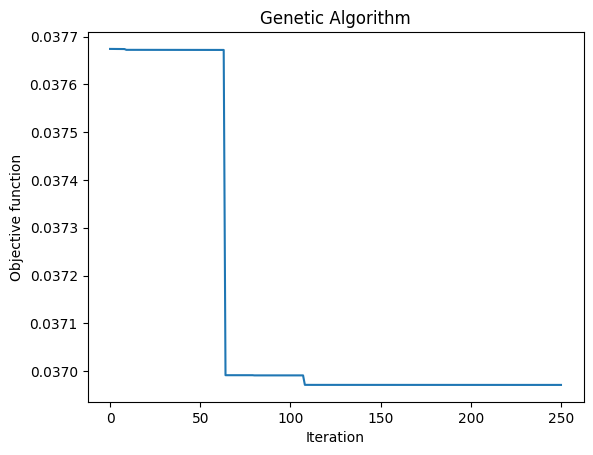

Kp = 316.02773026866043, Kd = 466.9453139755625, Ki = 53.1898566581915
0.00209220807850327 0.001158186614885739 0


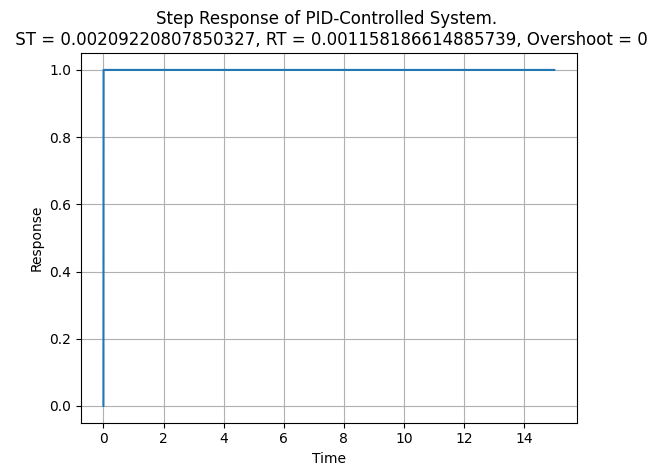

 The best solution found:                                                                           
 [498.57268141 363.97753243  52.69602672]

 Objective function:
 0.03674788373901035


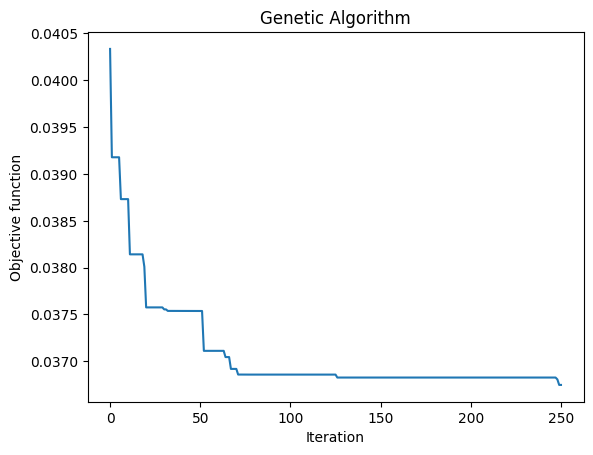

Kp = 363.9775324258634, Kd = 498.5726814087634, Ki = 52.69602671987809
0.001959527718986065 0.001084738558724429 0


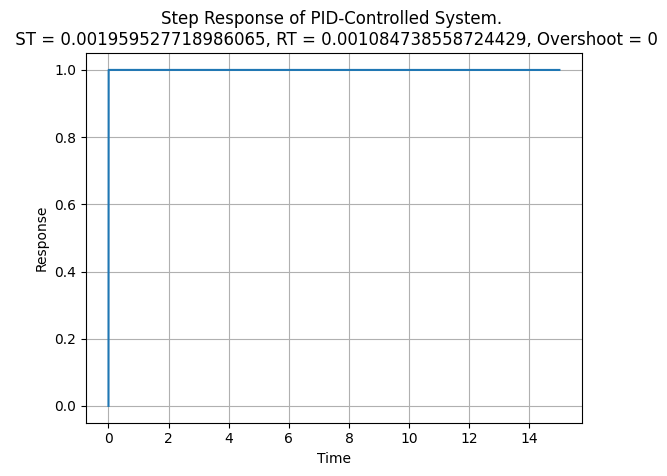

 The best solution found:                                                                           
 [494.15025535 339.28176447  55.34713316]

 Objective function:
 0.036777386791764274


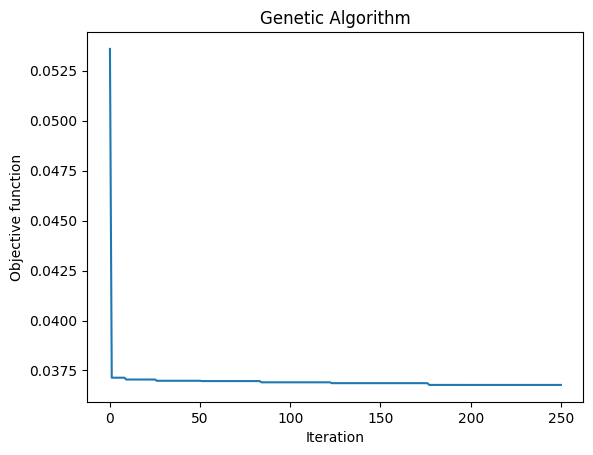

Kp = 339.2817644735157, Kd = 494.1502553482419, Ki = 55.34713316155067
0.001977023186087603 0.0010944235494413515 0


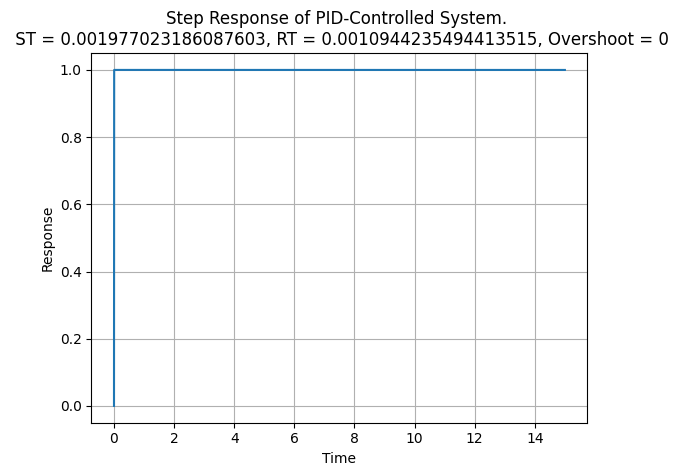

 The best solution found:                                                                           
 [492.17227705 338.15779873  25.3783184 ]

 Objective function:
 0.03679078189275037


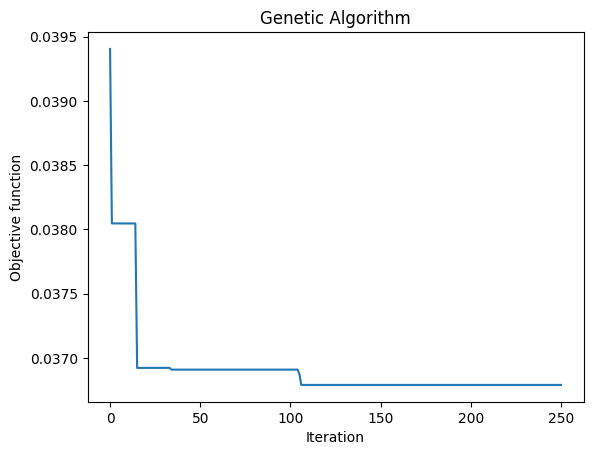

Kp = 338.1577987343329, Kd = 492.17227704571644, Ki = 25.37831839583839
0.001984969856951892 0.0010988225993840831 0


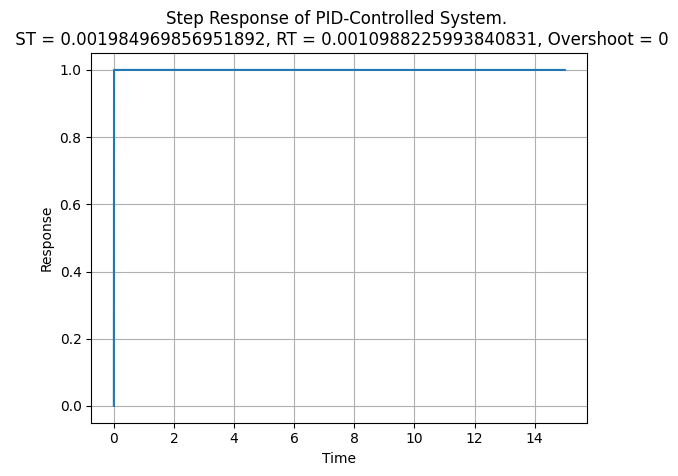

 The best solution found:                                                                           
 [497.85308335 346.25428631  60.07785768]

 Objective function:
 0.0367526041674742


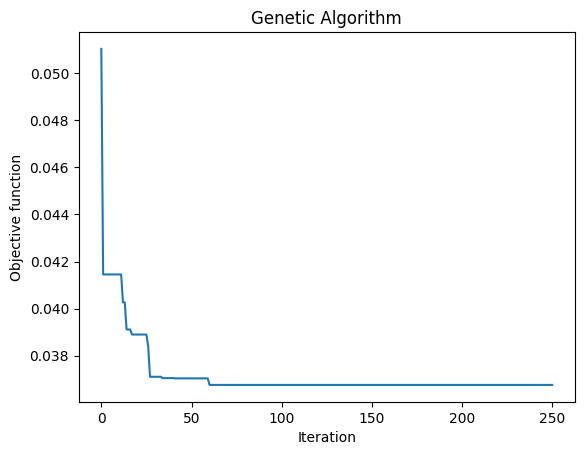

Kp = 346.25428631009333, Kd = 497.85308335478726, Ki = 60.07785767693646
0.00196232628561826 0.0010862877652529652 0


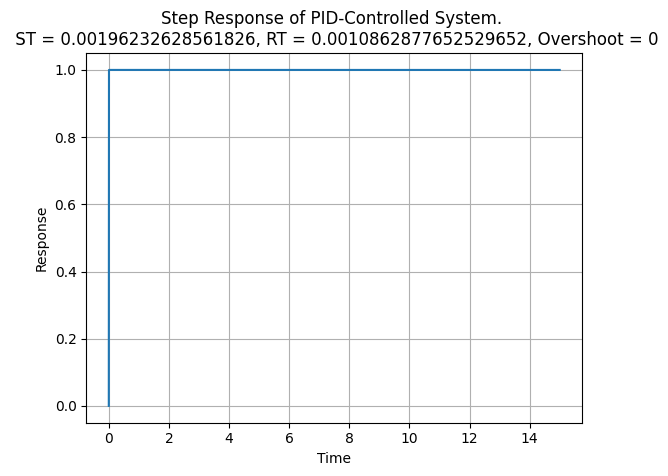

In [4]:
varbound=np.array([[-500,500]]*3)
algorithm_param = {'max_num_iteration': 250,\
                'population_size':25,\
                'mutation_probability':0.15,\
                'elit_ratio': 0.01,\
                'crossover_probability': 0.7,\
                'parents_portion': 0.3,\
                'crossover_type':'uniform',\
                'max_iteration_without_improv':None}

results = None 


for i in range(5):
    model=ga(function=fitness_func,\
                dimension=3,\
                variable_type='real',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)
    
    model.run()

    optimal_ctrl_system = create_control_system_num(num, den)

    v = model.output_dict['variable']

    print(f'Kp = {v[1]}, Kd = {v[0]}, Ki = {v[2]}')
    a, b, c, response, time, system = optimal_ctrl_system(v)
    print(a, b, c)
    plot_response(system)

    if results is None:
        results = np.array(model.report) 
    else:
        results = np.vstack((results,np.array(model.report)))


In [ ]:
results_1 = optimize_pid_values(num, den)

In [5]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 150,\
                   'population_size':20,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_1 = None 

num = [4]
den = [1, 0.5, 0]

for i in range(10):
    model_1=ga(function=create_eval_study(num, den, evaluator, scale=[1,1]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    model_1.run()

    optimal_ctrl_system = create_control_system(num, den)

    #Get geneticalgorithm best solution
    v = model_1.output_dict['variable'].astype(int)
    R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
    C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
    
    Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
    Kd = R[3]*R[1]*C[0]/R[2]
    Ki = R[3]/(R[0]*R[2]*C[0])
    print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')
    _, _, _, response, time = optimal_ctrl_system(v)
    plot_response(response, time)

    if results_1 is None:
        results_1 = np.array(model_1.report) 
    else:
        results_1 = np.vstack((results_1,np.array(model_1.report)))




NameError: name 'create_eval_study' is not defined

In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_1.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Second Case study

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 150,\
                   'population_size':20,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_2 = None 

num = [1]
#s(s+1)(s+5) = s^3 + 6s^2 + 5s
den = [3, 6, 5, 0]

optimal_ctrl_system = create_control_system(num, den)

for i in range(10):
    model_2=ga(function=create_eval_study(num, den, evaluator, scale=[15, 15, 100]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    model_2.run()

    v = model_2.output_dict['variable'].astype(int)
    R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
    C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
    
    Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
    Kd = R[3]*R[1]*C[0]/R[2]
    Ki = R[3]/(R[0]*R[2]*C[0])
    print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')
    _, _, _, response, time = optimal_ctrl_system(v)
    plot_response(response, time)


    if results_2 is None:
        results_2 = np.array(model_2.report) 
    else:
        results_2 = np.vstack((results_2,np.array(model_2.report)))

In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_2.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Third Case Study

In [ ]:
# Original transfer function coefficients
numerator = [5]
denominator = [15, 8, 1]

# Padé approximation order
order = 2  # Second-order approximation

# Create the Padé approximation
num_approx, den_approx = ctrl.pade(order, 1)  # Use the Padé approximation function

# Create the polynomial transfer function approximation
approx_num = np.convolve(numerator, num_approx)
approx_den = np.convolve(denominator, den_approx)

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 150,\
                   'population_size':50,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_3 = None 

for i in range(10):
    model_3=ga(function=create_eval_study(approx_num, approx_den, evaluator, scale=[15, 15, 100]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)

    model_3.run()

    v = model_3.output_dict['variable'].astype(int)
    R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
    C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
    
    Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
    Kd = R[3]*R[1]*C[0]/R[2]
    Ki = R[3]/(R[0]*R[2]*C[0])
    print(f'Kp = {Kp}, Kd = {Kd}, Ki = {Ki}')
    _, _, _, response, time = optimal_ctrl_system(v)
    plot_response(response, time)


    if results_3 is None:
        results_3 = np.array(model_3.report) 
    else:
        results_3 = np.vstack((results_3,np.array(model_3.report)))

In [ ]:
optimal_ctrl_system = create_control_system(approx_num, approx_den)

#Get geneticalgorithm best solution
v = model_3.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Fourth Case study

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)

algorithm_param = {'max_num_iteration': 150,\
                   'population_size':20,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_4 = None 

num = [1, 5, 6]

den = [1, 6, 5, 0]

for i in range(10):
    model_4=ga(function=create_eval_study(num, den, evaluator, scale=[5, 5, 100]),\
                dimension=12,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)
    
    model_4.run()
    if results_4 is None:
        results_4 = np.array(model_4.report) 
    else:
        results_4 = np.vstack((results_4,np.array(model_4.report)))

In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_4.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)

## Fifth Case study - DC Motor

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

#varbound=np.array([[0,23], [2,5]]*4 + [[0,23], [-12, -6]]*2)
varbound=np.array([[-500,500]]*3)
algorithm_param = {'max_num_iteration': 250,\
                   'population_size':25,\
                   'mutation_probability':0.15,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

results_5 = None 

num = [5.5]

den = [0.13, 1, 0]

for i in range(1):
    model_5=ga(function=create_eval_study_num(num, den, evaluator, scale=[5, 5, 100]),\
                dimension=3,\
                variable_type='real',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)
    
    model_5.run()

    optimal_ctrl_system = create_control_system_num(num, den)
    res = create_eval_study_num(num, den, evaluator, scale=[5, 5, 100], show_plot=True)
    #Get geneticalgorithm best solution
    v = model_5.output_dict['variable']
    # R = [R_VALUES[v[i]]*10**(v[i+1]) for i in range(0, 8, 2)]
    # C = [float(C_VALUES[v[i]])*10**(float(v[i+1])) for i in range(8, 11, 2)]
    
    # Kp = R[3]*(R[0]*C[0] + R[1]*C[1])/(R[2]*C[0]*C[1])
    # Kd = R[3]*R[1]*C[0]/R[2]
    # Ki = R[3]/(R[0]*R[2]*C[0])
    print(f'Kp = {v[1]}, Kd = {v[0]}, Ki = {v[2]}')
    _, _, _, response, time, system = optimal_ctrl_system(v)
    # plot_response(response, time)
    print(res(v))

    if results_5 is None:
        results_5 = np.array(model_5.report) 
    else:
        results_5 = np.vstack((results_5,np.array(model_5.report)))

In [ ]:
optimal_ctrl_system = create_control_system(num, den)

#Get geneticalgorithm best solution
v = model_5.output_dict['variable'].astype(int)
_, _, _, response, time = optimal_ctrl_system(v)
plot_response(response, time)